# Evaluate signature AMR genes in predicting 30 day mortality

In [1]:
import pandas as pd


pd.set_option("display.max_columns", None) # show all cols
pd.set_option('display.max_colwidth', None) # show full width of showing cols
pd.set_option("display.expand_frame_repr", False) # print cols side by side as it's supposed to be

## Read tokens from bed files

In [2]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'ECOLI')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id
0,1,1,3,GAA,0.024555,AH21B049
1,1,4,12,AAACCCCGG,0.019281,AH21B049
2,1,13,17,TCAAT,0.042749,AH21B049
3,1,18,22,AAGGC,0.058446,AH21B049
4,1,23,27,CGGGG,-0.002272,AH21B049
...,...,...,...,...,...,...
247349726,5,259913,259920,GCTACCCG,0.012245,ALF22C077
247349727,5,259921,259928,TTGGTGTG,0.000125,ALF22C077
247349728,5,259929,259938,CCTGTTCCGT,-0.000540,ALF22C077
247349729,5,259939,259942,GGCC,0.024973,ALF22C077


## Calculate token length

In [3]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,1,3,GAA,0.024555,AH21B049,3
1,1,4,12,AAACCCCGG,0.019281,AH21B049,9
2,1,13,17,TCAAT,0.042749,AH21B049,5
3,1,18,22,AAGGC,0.058446,AH21B049,5
4,1,23,27,CGGGG,-0.002272,AH21B049,5
...,...,...,...,...,...,...,...
247349726,5,259913,259920,GCTACCCG,0.012245,ALF22C077,8
247349727,5,259921,259928,TTGGTGTG,0.000125,ALF22C077,8
247349728,5,259929,259938,CCTGTTCCGT,-0.000540,ALF22C077,10
247349729,5,259939,259942,GGCC,0.024973,ALF22C077,4


## High-score tokens

### Obtain high-score tokens

In [4]:
highscoreDf = bedDf.sort_values(by=['score'], ascending=False)[:1000]
highscoreDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
106971408,5,275000,275001,CG,0.994362,AH18L059,2
197943648,4,402509,402513,TCGAT,0.991059,ALF22L083,5
197109127,1,1197500,1197506,CGTTGGC,0.984545,ALF22H044,7
117870964,1,622506,622509,GCAG,0.971440,AH19H076,4
220974321,4,240022,240024,TCA,0.962870,ALF22D139,3
...,...,...,...,...,...,...,...
233658566,3,375156,375161,TTCCCA,0.357662,AH19D073,6
155252028,3,400764,400769,GGTTTT,0.357557,ALF22L072,6
33317553,2,378264,378269,GGTTTT,0.357557,AH21F008,6
130613306,1,592562,592571,AAATGCATTT,0.357203,AH21B054,10


In [5]:
highscoreDf.shape

(1000, 7)

### Obtain token length distribution of high-score tokens

In [6]:
highscoreDf.token_length.value_counts()

token_length
6     286
7     203
5     135
4     117
3      78
8      71
9      54
10     24
2      10
11      9
1       8
16      5
Name: count, dtype: int64

<Axes: xlabel='token_length', ylabel='Count'>

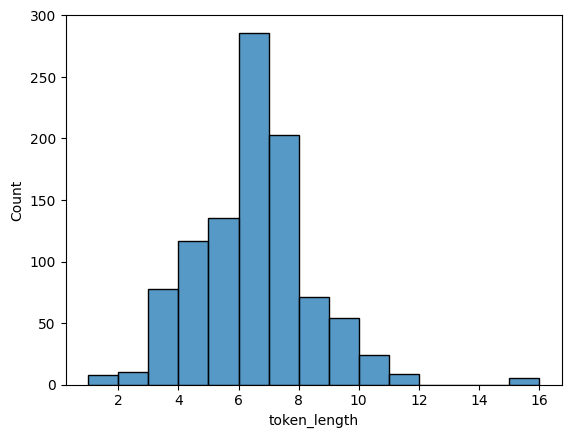

In [8]:
import seaborn as sns

sns.histplot(highscoreDf.token_length, binwidth=1)

## Read amrfinder annotations

In [9]:
import os

import pandas as pd

from pathlib import Path


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

overlappingGenesDict = {}
overlappingAnnotationsDict = {}

for tokenLengthCutoff in range(5, 11):
    print('tokenLengthCutoff: ', str(tokenLengthCutoff))
    tokensDf = highscoreDf[highscoreDf.token_length == tokenLengthCutoff]
    overlappingDfList = []
    for tubeId in tokensDf.tube_id.unique():
        tubeidHighscoreDf = highscoreDf[highscoreDf.tube_id == tubeId]
        amrfinderFile = Path(amrfinderDir, tubeId + '_amr_results.txt')
        if(amrfinderFile.exists()):
            amrfinderDf = pd.read_csv(amrfinderFile, sep='\t')
            mergedDf = tubeidHighscoreDf.merge(
                amrfinderDf,
                how='inner',
                left_on = ['contig_id'],
                right_on = ['Contig id'],
            )
            mergedDf['tube_code'] = tubeId
            tubeidOverlappingDf = mergedDf[(mergedDf.start_position >= mergedDf.Start) & (mergedDf.end_position <= mergedDf.Stop)]
            overlappingDfList.append(mergedDf)

    overlappingDf = pd.concat(overlappingDfList, ignore_index=True)

    overlappingGenesDict['Token Length = ' + str(tokenLengthCutoff)] = overlappingDf['Gene symbol'].unique()
    overlappingAnnotationsDict['Token Length = ' + str(tokenLengthCutoff)] = overlappingDf

tokenLengthCutoff:  5
tokenLengthCutoff:  6
tokenLengthCutoff:  7
tokenLengthCutoff:  8
tokenLengthCutoff:  9
tokenLengthCutoff:  10


## Generate upset plot

/home/vmadmin/workspace/alfred-data-analysis/.venv/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/vmadmin/workspace/alfred-data-analysis/.venv/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the 

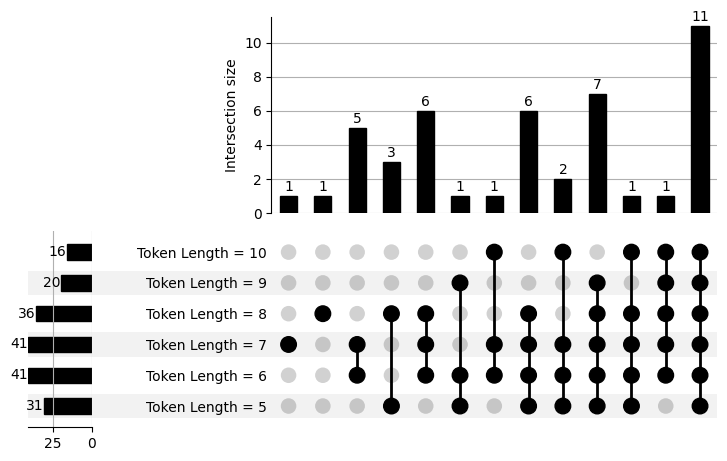

In [10]:
from upsetplot import UpSet

from upsetplot import from_contents


ax_dict = UpSet(from_contents(overlappingGenesDict), show_counts=True, sort_categories_by='input').plot()

## Obtain singature genes

In [11]:
singatureGenes = set()
singatureGenes.update(set.intersection(*[set([v for v in value if str(v) != 'nan']) for key, value in overlappingGenesDict.items()]))
singatureGenes

{'acrF',
 'asr',
 'blaEC',
 'emrE',
 'fdeC',
 'iss',
 'mdtM',
 'sslE',
 'ybtP',
 'ybtQ',
 'ymgB'}

## Create AMR genes data matrix

In [12]:
allAnnotationsDf = pd.concat([value for key, value in overlappingAnnotationsDict.items()], ignore_index=True)
allAnnotationsDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description,tube_code
0,4,402509,402513,TCGAT,0.991059,ALF22L083,5,NaN,4,288417,288746,-,emrE,multidrug efflux SMR transporter EmrE,plus,STRESS,BIOCIDE,EFFLUX,EFFLUX,BLASTX,110,110,100.0,98.18,110,CAA77936.1,multidrug efflux SMR transporter EmrE,NaN,NaN,ALF22L083
1,4,402509,402513,TCGAT,0.991059,ALF22L083,5,NaN,4,346859,348658,-,ybtQ,yersiniabactin ABC transporter ATP-binding/permease protein YbtQ,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,600,600,100.0,99.67,600,AAC69584.1,yersiniabactin ABC transporter ATP-binding/permease protein YbtQ,NaN,NaN,ALF22L083
2,4,402509,402513,TCGAT,0.991059,ALF22L083,5,NaN,4,348648,350447,-,ybtP,yersiniabactin ABC transporter ATP-binding/permease protein YbtP,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,600,600,100.0,99.67,600,CAA21388.1,yersiniabactin ABC transporter ATP-binding/permease protein YbtP,NaN,NaN,ALF22L083
3,5,380015,380020,CGCATC,0.789321,ALF22L083,6,NaN,5,186939,188069,-,blaEC,BlaEC family class C beta-lactamase,plus,AMR,AMR,BETA-LACTAM,BETA-LACTAM,BLASTX,377,377,100.0,99.73,377,AAZ85965.1,cephalosporin-hydrolyzing class C beta-lactamase EC-5,NaN,NaN,ALF22L083
4,5,380015,380020,CGCATC,0.789321,ALF22L083,6,NaN,5,325030,326034,-,papG-III,P fimbria tip G-adhesin PapG-III,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,335,335,100.0,97.91,335,CAA43558.1,P fimbria tip G-adhesin PapG-III,NaN,NaN,ALF22L083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1749,1,592600,592610,TATAATGCGCC,0.427181,AH21B054,11,NaN,1,390900,392318,-,espX1,type III secretion system effector EspX1,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,473,473,100.0,93.02,473,ADD54679.1,type III secretion system effector EspX1,NaN,NaN,AH21B054
1750,3,92783,92789,AGCCGGA,0.375737,AH21B054,7,NaN,3,110688,111017,+,emrE,multidrug efflux SMR transporter EmrE,plus,STRESS,BIOCIDE,EFFLUX,EFFLUX,BLASTX,110,110,100.0,98.18,110,CAA77936.1,multidrug efflux SMR transporter EmrE,NaN,NaN,AH21B054
1751,1,592562,592571,AAATGCATTT,0.357203,AH21B054,10,NaN,1,109553,110683,-,blaEC,BlaEC family class C beta-lactamase,plus,AMR,AMR,BETA-LACTAM,BETA-LACTAM,BLASTX,377,377,100.0,98.14,377,WP_063610930.1,class C extended-spectrum beta-lactamase EC-15,NaN,NaN,AH21B054
1752,1,592562,592571,AAATGCATTT,0.357203,AH21B054,10,NaN,1,288362,289591,-,mdtM,multidrug efflux MFS transporter MdtM,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,410,410,100.0,98.05,410,AAC77293.1,multidrug efflux MFS transporter MdtM,NaN,NaN,AH21B054


In [15]:
signatureAnnotationsDf = allAnnotationsDf[allAnnotationsDf['Gene symbol'].isin(singatureGenes)]
signatureAnnotationsDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description,tube_code
0,4,402509,402513,TCGAT,0.991059,ALF22L083,5,NaN,4,288417,288746,-,emrE,multidrug efflux SMR transporter EmrE,plus,STRESS,BIOCIDE,EFFLUX,EFFLUX,BLASTX,110,110,100.0,98.18,110,CAA77936.1,multidrug efflux SMR transporter EmrE,NaN,NaN,ALF22L083
1,4,402509,402513,TCGAT,0.991059,ALF22L083,5,NaN,4,346859,348658,-,ybtQ,yersiniabactin ABC transporter ATP-binding/permease protein YbtQ,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,600,600,100.0,99.67,600,AAC69584.1,yersiniabactin ABC transporter ATP-binding/permease protein YbtQ,NaN,NaN,ALF22L083
2,4,402509,402513,TCGAT,0.991059,ALF22L083,5,NaN,4,348648,350447,-,ybtP,yersiniabactin ABC transporter ATP-binding/permease protein YbtP,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,600,600,100.0,99.67,600,CAA21388.1,yersiniabactin ABC transporter ATP-binding/permease protein YbtP,NaN,NaN,ALF22L083
3,5,380015,380020,CGCATC,0.789321,ALF22L083,6,NaN,5,186939,188069,-,blaEC,BlaEC family class C beta-lactamase,plus,AMR,AMR,BETA-LACTAM,BETA-LACTAM,BLASTX,377,377,100.0,99.73,377,AAZ85965.1,cephalosporin-hydrolyzing class C beta-lactamase EC-5,NaN,NaN,ALF22L083
11,2,402532,402536,TCGAT,0.946905,ALF22G012,5,NaN,2,288451,288780,-,emrE,multidrug efflux SMR transporter EmrE,plus,STRESS,BIOCIDE,EFFLUX,EFFLUX,BLASTX,110,110,100.0,98.18,110,CAA77936.1,multidrug efflux SMR transporter EmrE,NaN,NaN,ALF22G012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,1,592600,592610,TATAATGCGCC,0.427181,AH21B054,11,NaN,1,109553,110683,-,blaEC,BlaEC family class C beta-lactamase,plus,AMR,AMR,BETA-LACTAM,BETA-LACTAM,BLASTX,377,377,100.0,98.14,377,WP_063610930.1,class C extended-spectrum beta-lactamase EC-15,NaN,NaN,AH21B054
1748,1,592600,592610,TATAATGCGCC,0.427181,AH21B054,11,NaN,1,288362,289591,-,mdtM,multidrug efflux MFS transporter MdtM,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,410,410,100.0,98.05,410,AAC77293.1,multidrug efflux MFS transporter MdtM,NaN,NaN,AH21B054
1750,3,92783,92789,AGCCGGA,0.375737,AH21B054,7,NaN,3,110688,111017,+,emrE,multidrug efflux SMR transporter EmrE,plus,STRESS,BIOCIDE,EFFLUX,EFFLUX,BLASTX,110,110,100.0,98.18,110,CAA77936.1,multidrug efflux SMR transporter EmrE,NaN,NaN,AH21B054
1751,1,592562,592571,AAATGCATTT,0.357203,AH21B054,10,NaN,1,109553,110683,-,blaEC,BlaEC family class C beta-lactamase,plus,AMR,AMR,BETA-LACTAM,BETA-LACTAM,BLASTX,377,377,100.0,98.14,377,WP_063610930.1,class C extended-spectrum beta-lactamase EC-15,NaN,NaN,AH21B054


In [54]:
signatureDataDf = signatureAnnotationsDf[['tube_id', 'Gene symbol']].drop_duplicates()
# Get one hot encoding of columns B
one_hot = pd.get_dummies(signatureDataDf['Gene symbol'])
# Drop column B as it is now encoded
signatureDataDf = signatureDataDf.drop('Gene symbol',axis = 1)
# Join the encoded df
signatureDataDf = signatureDataDf.join(one_hot)
signatureDataDf = signatureDataDf.loc[:, (signatureDataDf != 0).any(axis=0)]
signatureDataDf = signatureDataDf*1
signatureDataDf


,tube_id,acrF,asr,blaEC,emrE,fdeC,iss,mdtM,sslE,ybtP,ybtQ,ymgB
0,ALF22L083,0,0,0,1,0,0,0,0,0,0,0
1,ALF22L083,0,0,0,0,0,0,0,0,0,1,0
2,ALF22L083,0,0,0,0,0,0,0,0,1,0,0
3,ALF22L083,0,0,1,0,0,0,0,0,0,0,0
11,ALF22G012,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1578,AH19K002,0,0,0,0,0,0,0,1,0,0,0
1616,ALF22K178,0,0,0,0,0,0,0,0,0,1,0
1617,ALF22K178,0,0,0,0,0,0,0,0,1,0,0
1631,AH19J032,0,0,0,0,0,0,0,0,0,0,1


## Read mapping information

In [27]:
import os

import pandas as pd


demoTrainDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_train.csv', sep='\t')
demoTestDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_test.csv', sep='\t')
demoValidateDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_validate.csv', sep='\t')
demoDf = pd.concat([demoTrainDf, demoTestDf, demoValidateDf], ignore_index=True)
demoDf

,person_id,visit_occurrence_id,TYPE,COUNTRY_OF_BIRTH,SEX,Age_Bin,JOURNEY_ID
0,678487,3312694,Emergency,Australia,Male,"(60, 70]",3312694
1,2094045,9199249,Emergency,Australia,Male,"(20, 30]",9199249
2,2107813,9410987,Emergency,Australia,Male,"(50, 60]",9410987
3,2083212,602890,Inpatient,Australia,Female,"(40, 50]",9039437
4,2083212,9039437,Emergency,Australia,Female,"(40, 50]",9039437
...,...,...,...,...,...,...,...
7194,2603535,16588204,Inpatient,Australia,Male,"(60, 70]",16588204
7195,2603535,16709341,Inpatient,Australia,Male,"(60, 70]",16709341
7196,2603535,16651755,Inpatient,Australia,Male,"(60, 70]",16651755
7197,2098616,16872774,Emergency,Australia,Female,"(80, 90]",16872774


In [ ]:
import os

mappingDf = pd.read_csv(os.environ['GENOMICS_DATA_BASE'] + '/patient_tube_id_mapping_full.tsv', sep='\t')
mappingDf

,tube_code,PATIENT_ID,db_ID,pt_age,pt_gender,EPISODE_ID,hospital_admission,hospital_discharge,hospital_in_last_year,genome_species,species_reported,contig_number,length,tube_code_duplicate_or_old,date_of_collection,ID_number,location_additional_02,collected_from_original
0,AH19J072,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Escherichia coli,Escherichia coli,92,5131021,NaN,2019-10-30,19-303-0997,A-7EA;HAEM,Blood
1,AH19J074,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Streptococcus sp. D19,Streptococcus mitis group,84,2022991,NaN,2019-10-30,19-303-1174,A-7EA;HAEM,Blood Peripheral
2,AH19B003,526238.0,567AE,85,Male,640261.0,2019-02-04,2019-02-07,no,Escherichia coli,Escherichia coli,93,4942915,NaN,2019-02-03,19-034-1596,A-4WB;GMC,Blood
3,AH20A024,788941.0,3YBDS,58,Female,13194824.0,2020-01-16,2020-01-19,no,Escherichia coli,Escherichia coli,110,5149157,NaN,2020-01-16,20-016-2112,S-ED;Emergency,Blood Venous
4,AH20L041,1023735.0,2VJ78,42,Male,14210147.0,2020-12-18,2021-01-05,yes,Staphylococcus aureus,Staphylococcus aureus,46,2735216,NaN,2020-12-16,20-351-2856,Emergency Dept;nan,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,ALF22L076,639020.0,3S6HL,84,Male,17219899.0,2022-12-15,2022-12-20,yes,Streptococcus vestibularis,Streptococcus salivarius group,107,1938627,NaN,2022-12-15,22-349-2150,Ward 4WB,Blood Peripheral
3113,ALF22L089,655404.0,6EWBM,67,Female,NaN,NaN,NaN,NaN,Proteus columbae,Proteus vulgaris,152,3972219,NaN,2022-12-17,22-351-1465,Comm/Amb Clinic,Blood
3114,ALF22L138,2572048.0,YM5PJ,61,Male,NaN,NaN,NaN,NaN,Enterobacter roggenkampii,Enterobacter cloacae complex,66,4876179,NaN,2022-12-27,22-361-0202,Ward 7 East,Hick White Lum
3115,ALF23A102,2054964.0,5DYAH,35,Female,17294287.0,2023-01-12,2023-02-01,yes,Streptococcus constellatus,Streptococcus anginosus group,54,1869828,NaN,2023-01-11,23-011-3305,ICU,Blood Venous


In [29]:
mappedJourneyTubeIdsDf = mappingDf[['tube_code', 'PATIENT_ID', 'EPISODE_ID']].drop_duplicates().merge(
    demoDf[['person_id', 'visit_occurrence_id', 'JOURNEY_ID']],
    how='inner',
    left_on=['PATIENT_ID', 'EPISODE_ID'],
    right_on=['person_id', 'visit_occurrence_id']
).drop(
    columns=['PATIENT_ID', 'EPISODE_ID', 'visit_occurrence_id']
)[['person_id', 'JOURNEY_ID', 'tube_code']].drop_duplicates()
mappedJourneyTubeIdsDf

,person_id,JOURNEY_ID,tube_code
0,50056,13224842,AH20B011
1,62567,12645629,AH19G065
2,138108,14737781,AH21E052
3,211314,13955099,AH20J009
4,211314,13955099,KPN2214
...,...,...,...
512,2084373,16158768,ALF22C004
513,1058066,16759482,ALF22H089
514,2552781,16966609,ALF22J054
515,2638484,16969999,ALF22K143


## Read mortality labels

In [32]:
import os

import pandas as pd

from pathlib import Path


mortalityTrainDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_1', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_train.csv'), sep='\t')
mortalityTestDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_1', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_test.csv'), sep='\t')
mortalityValidateDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_1', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_validate.csv'), sep='\t')
mortalityDf = pd.concat([mortalityTrainDf, mortalityTestDf, mortalityValidateDf], ignore_index=True).drop_duplicates()
mortalityDf

,person_id,JOURNEY_ID,visit_occurrence_id,death_30_day
0,678487,3312694,3312694,0
1,2094045,9199249,9199249,0
2,2107813,9410987,9410987,1
5,2083212,9039437,602890,0
6,2083212,9039437,9039437,0
...,...,...,...,...
30815,2603535,16588204,16588204,0
30820,2603535,16709341,16709341,0
30832,2603535,16651755,16651755,0
30838,2098616,16872774,16872774,0


In [60]:
dataDf = mortalityDf.merge(
    mappedJourneyTubeIdsDf,
    on=['person_id', 'JOURNEY_ID'],
    how='inner'
).drop(
    columns=['visit_occurrence_id']
).drop_duplicates().merge(
    signatureDataDf,
    left_on=['tube_code'],
    right_on=['tube_id'],
    how='inner'
).drop(
    columns=['tube_code', 'tube_id']
)
dataDf = dataDf.loc[:, (dataDf != 0).any(axis=0)]
dataDf

,person_id,JOURNEY_ID,death_30_day,acrF,asr,blaEC,emrE,fdeC,iss,sslE,ybtP,ybtQ,ymgB
0,2137240,620642,0,0,0,0,0,1,0,0,0,0,0
1,2139360,9941051,0,0,0,0,0,1,0,0,0,0,0
2,2205347,10937623,0,0,0,0,0,1,0,0,0,0,0
3,2098600,635556,0,1,0,0,0,0,0,0,0,0,0
4,2098600,635556,0,0,1,0,0,0,0,0,0,0,0
5,2134356,9848663,0,0,0,0,1,0,0,0,0,0,0
6,2208679,12634488,0,1,0,0,0,0,0,0,0,0,0
7,1632550,12936831,0,0,0,0,0,0,0,0,0,0,1
8,2268611,12888272,1,1,0,0,0,0,0,0,0,0,0
9,2268611,12888272,1,0,0,0,0,0,0,1,0,0,0


In [62]:
dataDf[['death_30_day', 'acrF', 'asr', 'blaEC', 'emrE', 'fdeC', 'iss', 'sslE', 'ybtP', 'ybtQ', 'ymgB']].cov()

,death_30_day,acrF,asr,blaEC,emrE,fdeC,iss,sslE,ybtP,ybtQ,ymgB
death_30_day,0.131884,0.036232,-0.016908,-0.003382,-0.020290,0.005314,0.012077,0.030918,-0.016908,-0.016908,-0.010145
acrF,0.036232,0.160870,-0.021739,-0.004348,-0.026087,-0.021739,-0.013043,-0.017391,-0.021739,-0.021739,-0.013043
asr,-0.016908,-0.021739,0.099034,-0.002415,-0.014493,-0.012077,-0.007246,-0.009662,-0.012077,-0.012077,-0.007246
blaEC,-0.003382,-0.004348,-0.002415,0.021739,-0.002899,-0.002415,-0.001449,-0.001932,-0.002415,-0.002415,-0.001449
emrE,-0.020290,-0.026087,-0.014493,-0.002899,0.115942,-0.014493,-0.008696,-0.011594,-0.014493,-0.014493,-0.008696
fdeC,0.005314,-0.021739,-0.012077,-0.002415,-0.014493,0.099034,-0.007246,-0.009662,-0.012077,-0.012077,-0.007246
iss,0.012077,-0.013043,-0.007246,-0.001449,-0.008696,-0.007246,0.062319,-0.005797,-0.007246,-0.007246,-0.004348
sslE,0.030918,-0.017391,-0.009662,-0.001932,-0.011594,-0.009662,-0.005797,0.081159,-0.009662,-0.009662,-0.005797
ybtP,-0.016908,-0.021739,-0.012077,-0.002415,-0.014493,-0.012077,-0.007246,-0.009662,0.099034,-0.012077,-0.007246
ybtQ,-0.016908,-0.021739,-0.012077,-0.002415,-0.014493,-0.012077,-0.007246,-0.009662,-0.012077,0.099034,-0.007246


In [63]:
dataDf[['death_30_day', 'acrF', 'asr', 'blaEC', 'emrE', 'fdeC', 'iss', 'sslE', 'ybtP', 'ybtQ', 'ymgB']].corr()

,death_30_day,acrF,asr,blaEC,emrE,fdeC,iss,sslE,ybtP,ybtQ,ymgB
death_30_day,1.000000,0.248747,-0.147948,-0.063155,-0.164083,0.046498,0.133218,0.298844,-0.147948,-0.147948,-0.111903
acrF,0.248747,1.000000,-0.172232,-0.073521,-0.191014,-0.172232,-0.130271,-0.152204,-0.172232,-0.172232,-0.130271
asr,-0.147948,-0.172232,1.000000,-0.052058,-0.135250,-0.121951,-0.092240,-0.107770,-0.121951,-0.121951,-0.092240
blaEC,-0.063155,-0.073521,-0.052058,1.000000,-0.057735,-0.052058,-0.039375,-0.046004,-0.052058,-0.052058,-0.039375
emrE,-0.164083,-0.191014,-0.135250,-0.057735,1.000000,-0.135250,-0.102299,-0.119523,-0.135250,-0.135250,-0.102299
fdeC,0.046498,-0.172232,-0.121951,-0.052058,-0.135250,1.000000,-0.092240,-0.107770,-0.121951,-0.121951,-0.092240
iss,0.133218,-0.130271,-0.092240,-0.039375,-0.102299,-0.092240,1.000000,-0.081514,-0.092240,-0.092240,-0.069767
sslE,0.298844,-0.152204,-0.107770,-0.046004,-0.119523,-0.107770,-0.081514,1.000000,-0.107770,-0.107770,-0.081514
ybtP,-0.147948,-0.172232,-0.121951,-0.052058,-0.135250,-0.121951,-0.092240,-0.107770,1.000000,-0.121951,-0.092240
ybtQ,-0.147948,-0.172232,-0.121951,-0.052058,-0.135250,-0.121951,-0.092240,-0.107770,-0.121951,1.000000,-0.092240


<Axes: >

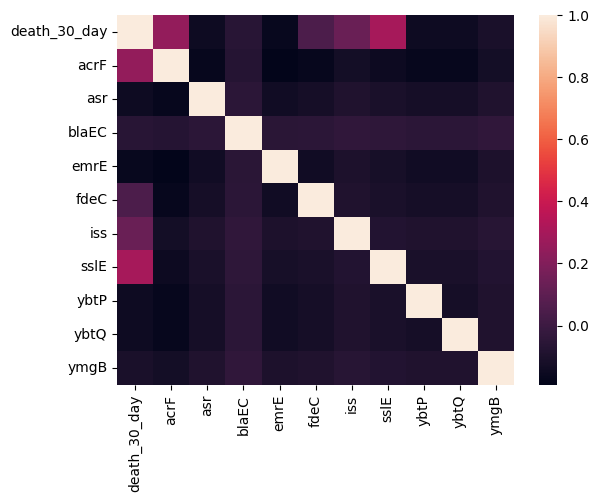

In [64]:
import seaborn as sns
%matplotlib inline

# plot the heatmap
sns.heatmap(dataDf[['death_30_day', 'acrF', 'asr', 'blaEC', 'emrE', 'fdeC', 'iss', 'sslE', 'ybtP', 'ybtQ', 'ymgB']].corr())

In [ ]:
from sklearn import linear_model


logr = linear_model.LogisticRegression()
logr.fit(dataDf[[]],y)